In [1]:
# 1.créer un nouvel env conda à partir du terminal
# conda create --name asr_rag python=3.10

# 2. activer cet environnement
# conda activate asr_rag

# 3. installer les dépendences
# pip install -r requirements.txt

# 4. installer ollama: https://www.ollama.com/download


# 5. installer le modème d'OllamaEmbeddings
# ollama pull embeddinggemma

# 6. créer une clé api sur openrouter pour utiliser des llm gratuitement

# 7. mettre votre clé dans le fichier .env (racine du repertoire courant)

In [2]:
from openai import OpenAI, AsyncOpenAI
import tiktoken
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
from langchain_ollama import OllamaEmbeddings
from langchain.schema.document import Document
from langchain_unstructured import UnstructuredLoader
from pathrag_retriever import create_graphdb, load_existing_graphdb, load_knowledgeGraph_vis
from PathRAG import QueryParam
import time
import os
from dotenv import load_dotenv

load_dotenv("./.env")

OPENROUTER_API_KEY=os.getenv("OPENROUTER_API_KEY")

tokens_counter = tiktoken.encoding_for_model("gpt-4o-mini")


/home/chougar/miniconda3/envs/pathrag/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Création ou chargement d'un graphe existant:
> Lorsque vous executer la cellule ci dessous, vous avez 2 options proposées:
> 1. Créer un nouveau graphe
> 2. Charger un graphe existant
> 
> Un prompt de sélection s'affichera en haut du notebook<br>
> Saisir l'action désirée dans le , suivre instructions

> Si vous voulez charger un graphe déjà crée et que vous ne savez plus son nom, retrouver le dans le fichier `graphrag_hashes.json` (dans la racine du dossier), attribut `Nom du doc`

> Si vous voulez modifier le LLM utilisé pour la création du graphe ou sa lecture, allez dans `pathrag_retriever.py`, sous la ligne 36( Choix du LLM OpenRouter), et prenez un modèle valide sur openrouter (attention à prendre un modèle qui supporte les `structured_outputs`, sur le site openrouter, à filtrer sur le paneau à gauche dans la liste des `Supported parameters`)

#### 1. Créer un graphe, ou charger en un déjà crée
Ci dessous un print des noms de docs disponibles

In [3]:
import pandas as pd

graph_names=pd.read_json("graphrag_hashes.json")

graph_names=graph_names.loc["Nom du doc", :].values.tolist()
for n in graph_names:
    print(n)

IA conscience
L-IA-notre-deuxieme-conscience


In [4]:
# 1.
import nest_asyncio

nest_asyncio.apply()

#==== params de base====

# Obligatoire: nom des sources
filename="audio-text.txt"
doc_name_graph="L-IA-notre-deuxieme-conscience"

# Optionnels:
# 1. modèle pour création du graph
# param 'OPENROUTER_MODEL_graph_creation', par défaut "deepseek/deepseek-chat-v3-0324"
# passer dans la fonction 'create_graphdb' un autre modèle si vous le souhaitez

# 2. modèle pour lecture du graph (questions/réponses)
# param 'OPENROUTER_MODEL_graph_read', par défaut "deepseek/deepseek-chat-v3-0324"
# passer dans la fonction 'load_existing_graphdb' un autre modèle si vous le souhaitez

#=======================

loader = UnstructuredLoader(filename)

txt_docs = loader.load()
text=""
for doc in txt_docs:
    text+=doc.page_content


graphrag_action=input("Saisir 'C' pour créer un nouveau graphe, 'L' pour charger un graphe existant")

# créer un nouveau graphe
messages=None

if graphrag_action=='C':
    print(f"Le nom de votre graphe est {doc_name_graph}")
    messages= create_graphdb(
        text=text, 
        doc_name=doc_name_graph, # il faut donner un nom unique permettant d'identifier et charger le graph les prochaines fois
    )
# charger un graphe existant
elif graphrag_action=='L':    
    print(f"Le nom de votre graphe est {doc_name_graph}")

    messages=load_existing_graphdb(
        doc_name_graph, 
        OPENROUTER_MODEL_graph_read="deepseek/deepseek-chat-v3.1"
    )
else:
    print('Option invalide')



if messages:
    pipeline_args={}
    for feedback in messages:
        if isinstance(feedback, str):
            print(feedback)
        elif isinstance(feedback, dict):
            pipeline_args[f"graphrag_pipeline_{doc_name_graph}"]=feedback["pipeline_args"]
            
print("Confirmation LLM read:", pipeline_args[f"graphrag_pipeline_{doc_name_graph}"]["llm_graph_QA"])

INFO:PathRAG:Logger initialized for working directory: /home/chougar/Documents/GitHub/experiments/associatif/IA audiovisuel/RAG/storage/graph_stores/9fa530c1fd2fc3cee4831f8edcd4822b9353bd24d1dbabef4a12af5a9f4501f5
INFO:PathRAG:Load KV llm_response_cache with 1 data
INFO:PathRAG:Load KV full_docs with 1 data
INFO:PathRAG:Load KV text_chunks with 11 data
INFO:PathRAG:Loaded graph from /home/chougar/Documents/GitHub/experiments/associatif/IA audiovisuel/RAG/storage/graph_stores/9fa530c1fd2fc3cee4831f8edcd4822b9353bd24d1dbabef4a12af5a9f4501f5/graph_chunk_entity_relation.graphml with 136 nodes, 120 edges
INFO:nano-vectordb:Load (132, 768) data
INFO:nano-vectordb:Init {'embedding_dim': 768, 'metric': 'cosine', 'storage_file': '/home/chougar/Documents/GitHub/experiments/associatif/IA audiovisuel/RAG/storage/graph_stores/9fa530c1fd2fc3cee4831f8edcd4822b9353bd24d1dbabef4a12af5a9f4501f5/vdb_entities.json'} 132 data
INFO:nano-vectordb:Load (120, 768) data
INFO:nano-vectordb:Init {'embedding_dim':

Le nom de votre graphe est L-IA-notre-deuxieme-conscience

        ----------------
        #### Graph RAG retriever
        Chargement de la base Graph RAG
    
**✅ Graph RAG chargé**
Confirmation LLM read: deepseek/deepseek-chat-v3.1


#### 2. Poser vos questions au graphrag

In [5]:

import asyncio

def stream_pathRAG_response(stream_resp):
    async def stream_response():        
        # Process the async generator
        async for chunk in stream_resp:
            print(chunk or "", end="")


    # Run in Streamlit's existing event loop
    loop = asyncio.get_event_loop()
    loop.run_until_complete(stream_response())

# question="résume ce texte dans sa langue source"
question = "Quels sont les principaux thèmes de ce texte ?"
# question="Quelles sont les questions qui peuvent être posées sur ce texte ?"
# question="Qui sont les intervenants dans ce texte ? "

resp=pipeline_args[f"graphrag_pipeline_{doc_name_graph}"]["rag"].query(
    query= question, 
    param=QueryParam(mode="hybrid", stream=True,)
)

stream_pathRAG_response(resp)

INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:PathRAG:kw_prompt result:
INFO:PathRAG:```json
{
  "high_level_keywords": ["Thèmes principaux", "Analyse de texte", "Contenu"],
  "low_level_keywords": ["Mots-clés", "Idées centrales", "Sujets abordés"]
}
```
INFO:PathRAG:Local query uses 40 entites, 15 relations, 3 text units
INFO:PathRAG:Global query uses 50 entites, 40 relations, 4 text units
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


response all ready
D'après les comptes-rendus de la discussion, plusieurs thèmes principaux structurent le débat sur l'intelligence artificielle.

### La nature et les limites de l'IA
Un thème central est l'évaluation des capacités réelles de l'intelligence artificielle. Les participants distinguent clairement l'optimisation algorithmique, domaine où l'IA excelle, de l'intelligence humaine authentique. L'IA est présentée comme une machine très performante pour traiter d'immenses quantités de données et produire des résultats dans des cadres contraints (comme un « exercice de style » littéraire), mais elle est fondamentalement dépourvue de conscience, d'émotions, de compréhension réelle et de motivation créatrice. Cette illusion de capacité, entretenue par un « storytelling » marketing, est un point crucial du débat.

### La créativité : Humaine vs. Artificielle
La question de savoir si l'IA peut être vraiment créative est abordée de manière approfondie. Les intervenants, comme Daniel A

============================
### RAG vectoriel
1. Embedding du document -> renseigner le nom de votre fichier dans `filename` et le nom de votre DB dans `doc_name_hybrid`
2. Setup du retriever / reranker / llm

In [6]:
#1
from langchain.vectorstores import Chroma
from langchain_ollama import OllamaEmbeddings
from langchain_community.retrievers import TFIDFRetriever
from langchain_unstructured import UnstructuredLoader

# chargement et fragmentation du doc
## Nom du doc à traiter
filename="audio-text.txt"

## Nom pour la base vectorielle
doc_name_hybrid="L-IA-notre-deuxieme-conscience_sample" # nom de doc significatif



#========= choix du modèle d'embedding
"""
    Le modèle choisi impacte la qualité du retriever, mais aussi le temps de traitement
    Si le déploiement est prévu sur une VM limitée, un modèle plus petit est nécessaire
    Explorer les comparatifs: https://huggingface.co/spaces/mteb/leaderboard

"""
# Utiliser OllamaEmbeddings avec le modèle local "embeddinggemma"
embeddings = OllamaEmbeddings(model="embeddinggemma")


# loader = UnstructuredFileLoader(filename)
loader = UnstructuredLoader(filename)

txt_doc = loader.load()
print(f"Loaded {len(txt_doc)} documents from {filename}")


#======== choix des paramètres de fragmentation
"""
    la taille du chunck_size est très important dans l'accès à une info précise
    une plus petite taille permet de cibler de courts passages contenant l'info nécessaire à des réponses précises:
        * lieu du projet
        * dates du projet
        * budget ...    
    l'envoi de passages plus courts au llm évite une dispertion de son attention
"""

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    length_function=len
)

docs = text_splitter.split_documents(txt_doc)

# Filter out complex metadata (e.g., lists, dicts)
docs = [Document(doc.page_content) for doc in docs]


# Conversion des docs en embeddings 
chroma_db = Chroma.from_documents(
    docs,
    embedding=embeddings,
    persist_directory=f'./storage/vector_scores/{doc_name_hybrid.replace(" ","_")}',
    collection_name=doc_name_hybrid.replace(" ","_")
)

retriever=chroma_db.as_retriever()





# ...existing code...
all_docs = chroma_db.get()
print("Nb de chuncks:", len(all_docs['documents']))  # This will print the total number of docs stored
# ...existing code...

Loaded 30 documents from audio-text.txt


INFO:chromadb.telemetry.product.posthog:Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event CollectionGetEvent: capture() takes 1 positional argument but 3 were given


Nb de chuncks: 1082


In [7]:


total_tokens=0
for c in all_docs["documents"][:40]:
    num_tokens = (tokens_counter.encode(c))
    print(c, f"\ntaille en car: {len(c)}", f"\ntaille en tokens: {len(num_tokens)}", "\n=============")
    total_tokens+=len(num_tokens)

print("total_tokens:", total_tokens)
    

[Nathan Devert]: France Culture. [Nathan Devert]: France Culture, sans préjuger. Nathan Devert. [Nathan Devert]: Comment expliquer les progrès phénoménaux que semble avoir accompli l'intelligence artificielle au cours de ces dernières années ? Depuis l'apparition de ChatGPT en novembre 2022, rapidement suivi par d'autres agents conversationnels, cette révolution technologique aux multiples aspects, paraît désormais capable d'exécuter de nombreuses tâches intellectuelles sur lesquelles l'esprit humain pensait jusqu'alors exercer un monopole. Écrire des articles, synthétiser des documents, traiter des données dans n'importe quel domaine, diagnostiquer une maladie, rédiger une dissertation, ou pourquoi pas, un scénario de film. Non contente de révolutionner le monde du travail, ses prouesses stupéfiantes de la technique soulèvent une interrogation majeure dans le domaine de la philosophie de l'esprit. Faut-il en déduire que l'intelligence, n'étant pas le propre d'un cerveau biologique et 

In [13]:
#2
from langchain.vectorstores import Chroma
from langchain.embeddings import OllamaEmbeddings
from langchain.retrievers import EnsembleRetriever
from langchain.retrievers import TFIDFRetriever
from langchain.schema.document import Document
from openai import OpenAI, AsyncOpenAI
import asyncio
import json
import re
import os


class RAG_hybrid():
    def __init__(self, model):
        self.model=model
        self.retrieved_docs=[]
        self.semantic_retriever_topK=60
        self.sparse_retriever_topK=60
        self.reranker_topK=30
        self.history=[]
        self.llm_client = AsyncOpenAI(
            base_url="https://openrouter.ai/api/v1",
            api_key=OPENROUTER_API_KEY,
        )
        self.reranker_llm="mistralai/mistral-small-3.1-24b-instruct"
        self.doc_name_hybrid=doc_name_hybrid
        self.reranker_score_thresh=5
        self.reranked_doc=[]

    def semanticRetriever(self):
        # 1. Semantic Retriever (Chroma + OllamaEmbeddings)
        embeddings = OllamaEmbeddings(model="embeddinggemma")
        if self.doc_name_hybrid == 'None':
            return "Error: fournir le nom du document"
        
        chroma_db = Chroma(
            persist_directory=f'./storage/vector_scores/{self.doc_name_hybrid.replace(" ","_")}',
            collection_name=self.doc_name_hybrid.replace(" ","_"),
            embedding_function=embeddings
        )

        semantic_retriever=chroma_db.as_retriever(
            search_type="mmr",
            search_kwargs={
                'k': self.semantic_retriever_topK, 
                'fetch_k': 60000
            }
        )    


        self.chroma_db=chroma_db
        self.semantic_retriever=semantic_retriever

        return "Success: ChromaDB setup avec succes"
    
    def sparseRetriever(self):
        # 2. Sparse Retriever (TF-IDF)

        # Récupérer TOUS les documents depuis Chroma
        all_data = self.chroma_db.get(include=["documents", "metadatas"])

        # Convertir en liste de `Document` objects pour LangChain
        docs = [
            Document(page_content=text, metadata=meta or {})  # <-- Si meta est None, on met {}
            for text, meta in zip(all_data["documents"], all_data["metadatas"])
        ]

        # Créer le retriever TF-IDF
        sparse_retriever = TFIDFRetriever.from_documents(
            documents=docs,
            k=self.sparse_retriever_topK,
            tfidf_params={"min_df": 1, "ngram_range": (1, 2)}
        )

        self.sparse_retriever= sparse_retriever
    
    def ensembleRetriever(self):
        # 3. Ensemble Retriever (Semantic + Sparse)
        ensemble_retriever = EnsembleRetriever(
            retrievers=[self.semantic_retriever, self.sparse_retriever],
            weights=[0.5, 0.5]
        )

        self.ensemble_retriever=ensemble_retriever

    async def reranker(self, results, query):


        async def llm_eval(doc, query):
            # system_prompt="""
            #     You're an expert assistant in reranking documents against a question.
            #     Your role is to compare the question with a document and give a score from 0 to 10, where:
            #     0=document out of context, unable to answer the question
            #     10=highly relevant document, able to answer the question
                                
            #     The expected final output is the score in json format
            #     Example:
            #     ```json{"score": 5}```
                
            #     It is very IMPORTANT to follow these instructions:
            #     * Reply only with the score
            #     * Always end your answer with this json format
            # """
            
            system_prompt="""
                Tu es un assistant expert chargé d’évaluer la pertinence d’un fragment de document par rapport à une question.

                Ton objectif est d’attribuer un score de 0 à 10 selon la capacité de ce fragment à contribuer à une réponse correcte et utile à la question, même s’il ne suffit pas à lui seul.

                Barème :
                0 = Hors sujet, aucune utilité pour répondre à la question  
                2 = Très faible lien thématique  
                4 = Lien partiel ou contextuel faible  
                6 = Apporte une information utile mais incomplète  
                8 = Très pertinent, information clé pour répondre  
                10 = Suffisant à lui seul pour répondre correctement  

                Consignes importantes :
                - Le fragment peut être incomplet mais néanmoins très pertinent s’il apporte une information essentielle.
                - Suppose que plusieurs fragments seront combinés pour produire la réponse finale.
                - Ne pénalise pas un document uniquement parce qu’il ne permet pas une réponse complète isolément.
                - Évalue la similarité sémantique réelle, pas seulement les mots-clés.
                - Ne fais aucune supposition au-delà du contenu explicite ou clairement implicite du fragment.
                - Ignore le style, la forme et la qualité rédactionnelle.

                Format de sortie strict :
                Réponds uniquement avec le score au format JSON suivant, sans aucun texte supplémentaire :

                ```json
                {"score": X}
            """            
            response = await self.llm_client.chat.completions.create(
                model=self.reranker_llm,
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": f"""
                        La question est: {query}\n Le document à évaluer est le suivant\n: {doc}
                    """
                    }
                ],
                temperature=0,
                extra_headers={
                    "HTTP-Referer": "audio-hybrid-rag-reranker",  # Optional for rankings
                    "X-Title": "audio-hybrid-rag-reranker",  # Optional for rankings
                },
                extra_body={
                    "user": "audio-hybrid-rag-reranker"
                }                
            )
            # Post-process to extract only the JSON part if extra text is present
            content = response.choices[0].message.content
            # Try to extract the JSON block if the model adds extra text
            match = re.search(r"\{.*?\}", content, re.DOTALL)
            if match:
                content = match.group(0)

            # extract score
            score=None
            try:
                score=content.replace("```json", "").replace("```", "")
                
                score= json.loads(score)
                score=score["score"]
            except Exception as e:
                print(e)                
            
            return {"content": doc, "score": score}


        tasks=[llm_eval(doc.page_content, query) for doc in results]
        scored_docs= await asyncio.gather(*tasks)
        i=1

        for doc in scored_docs:
          
            print(f'chunk {i} score: {doc["score"]}')
            i+=1

        filtred_docs=[d for d in scored_docs if int(d["score"])>=self.reranker_score_thresh]
        # print(f"scored docs; \n{scored_docs}")
        self.reranked_doc=filtred_docs
        filtred_docs=filtred_docs[:self.reranker_topK]
        print(
            "================================\n",
            "Nb of docs kept after the reranking:", 
            len(filtred_docs),
            "\n=============================="
        )
        return filtred_docs

    async def ask_llm(self, query):
        # 5. Final processing step with an LLM (e.g., OpenAI via OpenRouter)

        # init retrievers
        status=self.semanticRetriever()
        if "Error" in status:
            return status
        
        self.sparseRetriever()
        self.ensembleRetriever()

        # retrieve relevant docs
        results = self.ensemble_retriever.get_relevant_documents(query)
        print(f"Nb of retrieved docs: {len(results)}")

        # rerank
        scored_results=await self.reranker(results, query)
        
        # Concatenate retrieved documents for context
        context = "\n".join([f"Fragment: \n{doc['content']}\n" for doc in scored_results])
        
        tokens_counter = tiktoken.encoding_for_model("gpt-4o-mini")
        num_tokens = (tokens_counter.encode(context))
        print(f"Context lenght: {len(num_tokens)} tokens")

        llm_prompt = f"""
            Answer the question based **only** on the provided context.  

            - If the context contains enough information to provide a complete or partial answer, use it to formulate a detailed and factual response.  
            - If the context lacks relevant information, respond with: "I don't know."  

            ### **Context:**  
            {context}  

            ### **Question:**  
            {query}  

            ### **Answer:**  
            Provide a clear, factual, and well-structured response based on the available context. Avoid speculation or adding external knowledge.  
        """

        llm_completion = await self.llm_client.chat.completions.create(
            model=self.model,
            messages=[
                {"role": "system", "content": "You are an expert in document Q/A and document synthesis"},
                {"role": "user", "content": llm_prompt}
            ],
            temperature=0.2,
            stream=True,
            extra_headers={
                "HTTP-Referer": "audio-hybrid-rag-generation",  # Optional for rankings
                "X-Title": "audio-hybrid-rag-generation",  # Optional for rankings
            },
            extra_body={
                "user": "audio-hybrid-rag-generation"
            }
        )

        final_answer = ""
        print("Réponse:\n=========")
        async for chunk in llm_completion:
            if hasattr(chunk.choices[0].delta, "content") and chunk.choices[0].delta.content:
                final_answer += chunk.choices[0].delta.content
                print(chunk.choices[0].delta.content, end="", flush=True)
        
        self.history+=[
            {"role": "user", 'content': query},
            {"role": "assistant", "content": final_answer}
        ]
        
        return final_answer



In [14]:
rag_hybrid=RAG_hybrid(model="mistralai/mistral-small-3.2-24b-instruct")
# rag_hybrid=RAG_hybrid(model="mistralai/mistral-large-2512")
# rag_hybrid=RAG_hybrid(model="deepseek/deepseek-chat-v3-0324")
# 4. Ask a question
question = """
    Peux tu me faire une synthèse de ce texte en 4 parties : 
    1. Les idées principales à retenir.
    2. les faits / chiffres cités qui soutiennent ces idées  (en précisant qui les mentionne).
    3. les positions de chaque intervenant (en 1 à 2 phrases max pour chacun).
    4. les principaux points de désaccord, avec une courte citation à chaque fois.
"""
results = await rag_hybrid.ask_llm(question)

ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


Nb of retrieved docs: 60


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/c

chunk 1 score: 4
chunk 2 score: 6
chunk 3 score: 4
chunk 4 score: 6
chunk 5 score: 4
chunk 6 score: 2
chunk 7 score: 4
chunk 8 score: 4
chunk 9 score: 4
chunk 10 score: 6
chunk 11 score: 4
chunk 12 score: 6
chunk 13 score: 4
chunk 14 score: 6
chunk 15 score: 2
chunk 16 score: 4
chunk 17 score: 6
chunk 18 score: 6
chunk 19 score: 6
chunk 20 score: 6
chunk 21 score: 6
chunk 22 score: 2
chunk 23 score: 6
chunk 24 score: 6
chunk 25 score: 4
chunk 26 score: 6
chunk 27 score: 6
chunk 28 score: 6
chunk 29 score: 4
chunk 30 score: 6
chunk 31 score: 6
chunk 32 score: 6
chunk 33 score: 6
chunk 34 score: 6
chunk 35 score: 8
chunk 36 score: 6
chunk 37 score: 6
chunk 38 score: 6
chunk 39 score: 4
chunk 40 score: 6
chunk 41 score: 4
chunk 42 score: 6
chunk 43 score: 6
chunk 44 score: 6
chunk 45 score: 4
chunk 46 score: 4
chunk 47 score: 6
chunk 48 score: 4
chunk 49 score: 6
chunk 50 score: 6
chunk 51 score: 6
chunk 52 score: 8
chunk 53 score: 2
chunk 54 score: 8
chunk 55 score: 6
chunk 56 score: 4
c

INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Réponse:
### Synthèse du texte

#### 1. Les idées principales à retenir
- **Dévaluation de l'intelligence humaine** : L'intelligence artificielle (IA) pourrait dévaluer l'intelligence humaine, similaire à la dévaluation du travail humain par la révolution industrielle.
- **Limites de l'IA** : L'IA ne comprend pas, n'a pas de conscience, ni d'intentions, et ne peut pas reproduire la dimension poétique du langage humain.
- **Impact sur la société** : L'IA pourrait avoir des effets négatifs sur la société, notamment en infantilisant les humains et en les isolant.
- **Domestication de l'IA** : L'IA pourrait devenir une technologie normale, domestiquée, et ne pas remplacer complètement l'intelligence humaine.
- **Illusion de la conscience de l'IA** : La question de la conscience de l'IA est souvent exagérée et utilisée à des fins marketing.

#### 2. Faits / chiffres cités qui soutiennent ces idées
- **85 % des jeunes** trouvent que l'IA peut être un interlocuteur intime à leurs problèmes (V

#### Optimisation de l'IR avec HyDE

In [15]:
#2
from langchain.vectorstores import Chroma
from langchain.embeddings import OllamaEmbeddings
from langchain.retrievers import EnsembleRetriever
from langchain.retrievers import TFIDFRetriever
from langchain.schema.document import Document
from openai import OpenAI, AsyncOpenAI
import asyncio
import json
import re
import os



class RAG_hybrid_HyDE():
    def __init__(self, model):
        self.model=model
        self.retrieved_docs=[]
        self.semantic_retriever_topK=60
        self.sparse_retriever_topK=60
        self.reranker_topK=30
        self.history=[]
        self.llm_client = AsyncOpenAI(
            base_url="https://openrouter.ai/api/v1",
            api_key=OPENROUTER_API_KEY,
        )
        self.reranker_llm="mistralai/mistral-small-3.1-24b-instruct"
        self.doc_name_hybrid=doc_name_hybrid
        self.reranker_score_thresh=5
        self.reranked_doc=[]

    async def generate_hypothetical_document(self, query):
        system_prompt = """
            You are an expert assistant.
            Given a question, generate a hypothetical document
            that would correctly answer the question.
            The document must be factual, neutral, and informative.
            Do not mention that this is a hypothetical document.
        """

        response = await self.llm_client.chat.completions.create(
            model=self.model,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": query}
            ],
            temperature=0,
            extra_headers={
                "HTTP-Referer": "audio-hyde-rag",  # Optional for rankings
                "X-Title": "audio-hyde-rag",  # Optional for rankings
            },
            extra_body={
                "user": "audio-hyde-rag-query-document"
            }                            
        )

        return response.choices[0].message.content


    def semanticRetriever(self):
        # 1. Semantic Retriever (Chroma + OllamaEmbeddings)
        embeddings = OllamaEmbeddings(model="embeddinggemma")
        if self.doc_name_hybrid == 'None':
            return "Error: fournir le nom du document"
        
        chroma_db = Chroma(
            persist_directory=f'./storage/vector_scores/{self.doc_name_hybrid.replace(" ","_")}',
            collection_name=self.doc_name_hybrid.replace(" ","_"),
            embedding_function=embeddings
        )

        semantic_retriever=chroma_db.as_retriever(
            search_type="mmr",
            search_kwargs={'k': self.semantic_retriever_topK, 'fetch_k': 60000}
        )    


        self.chroma_db=chroma_db
        self.semantic_retriever=semantic_retriever

        return "Success: ChromaDB setup avec succes"
    
    def sparseRetriever(self):
        # 2. Sparse Retriever (TF-IDF)

        # Récupérer TOUS les documents depuis Chroma
        all_data = self.chroma_db.get(include=["documents", "metadatas"])
        self.all_docs=all_data

        # Convertir en liste de `Document` objects pour LangChain
        docs = [
            Document(page_content=text, metadata=meta or {})  # <-- Si meta est None, on met {}
            for text, meta in zip(all_data["documents"], all_data["metadatas"])
        ]

        # Créer le retriever TF-IDF
        sparse_retriever = TFIDFRetriever.from_documents(
            documents=docs,
            k=self.sparse_retriever_topK,
            tfidf_params={"min_df": 1, "ngram_range": (1, 2)}
        )

        self.sparse_retriever= sparse_retriever
    
    def ensembleRetriever(self):
        # 3. Ensemble Retriever (Semantic + Sparse)
        ensemble_retriever = EnsembleRetriever(
            retrievers=[self.semantic_retriever, self.sparse_retriever],
            weights=[0.5, 0.5]
        )

        self.ensemble_retriever=ensemble_retriever

    async def reranker(self, results, query):


        async def llm_eval(doc, query):
            system_prompt="""
                Tu es un assistant expert chargé d’évaluer la pertinence d’un fragment de document par rapport à une question.

                Ton objectif est d’attribuer un score de 0 à 10 selon la capacité de ce fragment à contribuer à une réponse correcte et utile à la question, même s’il ne suffit pas à lui seul.

                Barème :
                0 = Hors sujet, aucune utilité pour répondre à la question  
                2 = Très faible lien thématique  
                4 = Lien partiel ou contextuel faible  
                6 = Apporte une information utile mais incomplète  
                8 = Très pertinent, information clé pour répondre  
                10 = Suffisant à lui seul pour répondre correctement  

                Consignes importantes :
                - Le fragment peut être incomplet mais néanmoins très pertinent s’il apporte une information essentielle.
                - Suppose que plusieurs fragments seront combinés pour produire la réponse finale.
                - Ne pénalise pas un document uniquement parce qu’il ne permet pas une réponse complète isolément.
                - Évalue la similarité sémantique réelle, pas seulement les mots-clés.
                - Ne fais aucune supposition au-delà du contenu explicite ou clairement implicite du fragment.
                - Ignore le style, la forme et la qualité rédactionnelle.

                Format de sortie strict :
                Réponds uniquement avec le score au format JSON suivant, sans aucun texte supplémentaire :

                ```json
                {"score": X}

            """
            response = await self.llm_client.chat.completions.create(
                model=self.reranker_llm,
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": f"""
                        La question est: {query}\n Le document à évaluer est le suivant\n: {doc}
                    """
                    }
                ],
                temperature=0,
                extra_headers={
                    "HTTP-Referer": "audio-hyde-rag-reranker",  # Optional for rankings
                    "X-Title": "audio-hyde-rag-reranker",  # Optional for rankings
                },
                extra_body={
                    "user": "audio-hyde-rag-reranker"
                }                
            )
            
            # Post-process to extract only the JSON part if extra text is present
            content = response.choices[0].message.content
            # Try to extract the JSON block if the model adds extra text
            match = re.search(r"\{.*?\}", content, re.DOTALL)
            if match:
                content = match.group(0)

            # extract score
            score=None
            try:
                score=content.replace("```json", "").replace("```", "")
                
                score= json.loads(score)
                score=score["score"]
            except Exception as e:
                print(e)                
            
            return {"content": doc, "score": score}


        tasks=[llm_eval(doc.page_content, query) for doc in results]
        scored_docs= await asyncio.gather(*tasks)
        i=1

        for doc in scored_docs:
          
            print(f'chunk {i} score: {doc["score"]}')
            i+=1

        filtred_docs=[d for d in scored_docs if int(d["score"])>=self.reranker_score_thresh]
        # print(f"scored docs; \n{scored_docs}")
        self.reranked_doc=filtred_docs

        filtred_docs=filtred_docs[:self.reranker_topK]
        print(
            "================================\n",
            "Nb of docs kept after the reranking:", 
            len(filtred_docs),
            "\n=============================="
        )

        return filtred_docs

    def init_retrievers(self):
        # init retrievers
        status=self.semanticRetriever()
        if "Error" in status:
            return status
        
        self.sparseRetriever()
        self.ensembleRetriever()


    async def ask_llm(self, query):
        # 5. Final processing step with an LLM (e.g., OpenAI via OpenRouter)

        self.init_retrievers()

        # HyDE
        context=""
        for c in self.all_docs["documents"][:6]:
            context+=c
        context_and_query=f"""
            The query:
            {query}

            The context of the corpus:
            {context}

            Now generate a corresponding hypothetical document
        """
        hypothetical_doc = await self.generate_hypothetical_document(context_and_query)

        self.hypothetical_document=hypothetical_doc

        # double retireval (relevant docs to query + HyDE)
        results_query = self.ensemble_retriever.get_relevant_documents(query)
        results_hyde = self.ensemble_retriever.get_relevant_documents(hypothetical_doc)

        # Fusion + déduplication
        all_results = {doc.page_content: doc for doc in results_query + results_hyde}
        results = list(all_results.values())

        print(f"Nb of retrieved docs: {len(results)}")

        # rerank
        scored_results=await self.reranker(results, query)
        
        # Concatenate retrieved documents for context
        context = "\n".join([f"Fragment: \n{doc['content']}\n" for doc in scored_results])
        
        llm_prompt = f"""
            Answer the question based **only** on the provided context.  

            - If the context contains enough information to provide a complete or partial answer, use it to formulate a detailed and factual response.  
            - If the context lacks relevant information, respond with: "I don't know."  

            ### **Context:**  
            {context}  

            ### **Question:**  
            {query}  

            ### **Answer:**  
            Provide a clear, factual, and well-structured response based on the available context. Avoid speculation or adding external knowledge.  
        """

        num_tokens = (tokens_counter.encode(llm_prompt))
        
        print(f"Context lenght: {len(num_tokens)} tokens")


        llm_completion = await self.llm_client.chat.completions.create(
            model=self.model,
            messages=[
                {"role": "system", "content": "You are an expert in document Q/A and document synthesis"},
                {"role": "user", "content": llm_prompt}
            ],
            temperature=0.2,
            stream=True,
            extra_headers={
                "HTTP-Referer": "audio-hyde-rag-generation",  # Optional for rankings
                "X-Title": "audio-hyde-rag-generation",  # Optional for rankings
            },
            extra_body={
                "user": "audio-hyde-rag-generation"
            }                            
        )

        final_answer = ""
        print("Réponse:\n=========")
        async for chunk in llm_completion:
            if hasattr(chunk.choices[0].delta, "content") and chunk.choices[0].delta.content:
                final_answer += chunk.choices[0].delta.content
                print(chunk.choices[0].delta.content, end="", flush=True)
        
        self.history+=[
            {"role": "user", 'content': query},
            {"role": "assistant", "content": final_answer}
        ]
        
        return final_answer



In [19]:
rag_hyde=RAG_hybrid_HyDE(model="mistralai/mistral-small-3.2-24b-instruct")
# rag_hyde=RAG_hybrid_HyDE(model="mistralai/mistral-large-2512")
# rag_hyde=RAG_hybrid_HyDE(model="deepseek/deepseek-chat-v3-0324")

# 4. Ask a question
question = """
    Peux tu me faire une synthèse de ce texte en 4 parties : 
    1. Les idées principales à retenir.
    2. les faits / chiffres cités qui soutiennent ces idées  (en précisant qui les mentionne).
    3. les positions de chaque intervenant (en 1 à 2 phrases max pour chacun).
    4. les principaux points de désaccord, avec une courte citation à chaque fois.
"""
results = await rag_hyde.ask_llm(question)

ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Nb of retrieved docs: 73


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/c

chunk 1 score: 4
chunk 2 score: 6
chunk 3 score: 4
chunk 4 score: 6
chunk 5 score: 4
chunk 6 score: 2
chunk 7 score: 4
chunk 8 score: 4
chunk 9 score: 4
chunk 10 score: 6
chunk 11 score: 4
chunk 12 score: 6
chunk 13 score: 4
chunk 14 score: 6
chunk 15 score: 2
chunk 16 score: 4
chunk 17 score: 6
chunk 18 score: 6
chunk 19 score: 6
chunk 20 score: 6
chunk 21 score: 6
chunk 22 score: 2
chunk 23 score: 6
chunk 24 score: 6
chunk 25 score: 4
chunk 26 score: 6
chunk 27 score: 6
chunk 28 score: 6
chunk 29 score: 4
chunk 30 score: 6
chunk 31 score: 6
chunk 32 score: 6
chunk 33 score: 6
chunk 34 score: 6
chunk 35 score: 8
chunk 36 score: 6
chunk 37 score: 6
chunk 38 score: 6
chunk 39 score: 4
chunk 40 score: 6
chunk 41 score: 4
chunk 42 score: 6
chunk 43 score: 6
chunk 44 score: 6
chunk 45 score: 4
chunk 46 score: 4
chunk 47 score: 6
chunk 48 score: 4
chunk 49 score: 6
chunk 50 score: 6
chunk 51 score: 6
chunk 52 score: 6
chunk 53 score: 2
chunk 54 score: 8
chunk 55 score: 6
chunk 56 score: 4
c

INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Réponse:
### Synthèse du texte

#### 1. Les idées principales à retenir
- **Dévaluation de l'intelligence humaine** : L'IA pourrait dévaluer l'intelligence humaine, similaire à la dévaluation du travail humain par la révolution industrielle.
- **Limites de l'IA** : L'IA ne comprend pas, n'a pas de conscience, ni d'intentions, et ne peut pas reproduire la dimension poétique du langage humain.
- **Impact sur la société** : L'IA pourrait affecter l'inconscient humain et les relations sociales, notamment chez les adolescents et les adultes qui s'y confient.
- **Domestication de l'IA** : L'IA pourrait devenir une technologie normale, domestiquée, mais avec des usages à limiter, comme les compagnons IA.
- **Créativité et IA** : L'IA peut exceller dans des exercices de style, mais ne possède pas une véritable créativité humaine.
- **Illusion de la conscience de l'IA** : Il y a une illusion marketing autour de la conscience de l'IA, qui n'est pas réelle.

#### 2. Faits / chiffres cités
- **85 

In [20]:
from IPython.display import Markdown
print(rag_hyde.hypothetical_document)

**Synthèse du débat sur l'intelligence artificielle**

**1. Les idées principales à retenir**

- L'intelligence artificielle (IA) a accompli des progrès remarquables ces dernières années, notamment avec l'avènement de ChatGPT, et semble capable d'exécuter des tâches intellectuelles complexes.
- L'IA soulève des questions philosophiques majeures sur la nature de l'intelligence et de la conscience humaine.
- L'IA pourrait être un miroir de notre propre intelligence, révélant des aspects mécanisables de notre pensée.
- Un concours littéraire entre un humain et une IA a montré des résultats surprenants, remettant en question la singularité de la créativité humaine.

**2. Faits et chiffres cités**

- **Nathan Devert** mentionne l'apparition de ChatGPT en novembre 2022 et ses capacités à exécuter des tâches intellectuelles variées.
- **Nathan Devert** rapporte que Hervé Le Tellier, auteur primé, a déclaré être "absolument bluffé par la créativité littéraire de ChatGPT" et a même suggéré que 

In [57]:
#### Couts Graph VS vectoriel
import pandas

df_activity=pandas.read_csv("openrouter_activity.csv")

display(df_activity.shape)

#===== graph rag
graph_rag_activity={}
df_activity_graphrag_creation=df_activity[df_activity["user"]=="audio-graphrag-creation"]
graph_rag_activity["creation_tokens_input"]=df_activity_graphrag_creation["tokens_prompt"].sum().item()
graph_rag_activity["creation_tokens_output"]=(df_activity_graphrag_creation["tokens_reasoning"].sum()+df_activity_graphrag_creation["tokens_completion"].sum()).item()
graph_rag_activity["creation_cost_total"]=round(df_activity_graphrag_creation["cost_total"].sum().item(),2)

df_activity_graphrag_qa=df_activity[df_activity["user"]=="audio-graphrag-qa"]
graph_rag_activity["qa_tokens_input"]=df_activity_graphrag_qa["tokens_prompt"].sum().item()
graph_rag_activity["qa_tokens_output"]=(df_activity_graphrag_qa["tokens_reasoning"].sum()+df_activity_graphrag_qa["tokens_completion"].sum()).item()
graph_rag_activity["qa_cost_total"]=round(df_activity_graphrag_qa["cost_total"].sum().item(),4)

print("Graph-RAG:")
display(graph_rag_activity)


# ===== hybrid RAG 
hybrid_rag_activity={}
df_activity_hybrid_global=df_activity[df_activity["user"].str.contains("audio-hybrid")]
df_activity_hybrid_reranker=df_activity_hybrid_global[df_activity_hybrid_global["user"].str.contains("reranker")]
df_activity_hybrid_generation=df_activity_hybrid_global[df_activity_hybrid_global["user"].str.contains("generation")]

hybrid_rag_activity["reranker_tokens_input"]=df_activity_hybrid_reranker["tokens_prompt"].sum().item()
hybrid_rag_activity["reranker_tokens_output"]=(df_activity_hybrid_reranker["tokens_reasoning"].sum()+df_activity_hybrid_reranker["tokens_completion"].sum()).item()
hybrid_rag_activity["generation_tokens_input"]=df_activity_hybrid_generation["tokens_prompt"].sum().item()
hybrid_rag_activity["generation_tokens_output"]=(df_activity_hybrid_generation["tokens_reasoning"].sum()+df_activity_hybrid_generation["tokens_completion"].sum()).item()
hybrid_rag_activity["total_tokens_input"]=hybrid_rag_activity["reranker_tokens_input"]+hybrid_rag_activity["generation_tokens_input"]
hybrid_rag_activity["total_tokens_output"]=hybrid_rag_activity["reranker_tokens_output"]+hybrid_rag_activity["generation_tokens_output"]

hybrid_rag_activity["cost_total"]=round(df_activity_hybrid_global["cost_total"].sum().item(),4)


print("Hybrid-RAG:")
display(hybrid_rag_activity)


#======= hybrid RAG with HyDE
hybrid_hyde_rag_activity={}
df_activity_hyde_global=df_activity[df_activity["user"].str.contains("audio-hyde")]
df_activity_hyde_query_document=df_activity_hyde_global[df_activity_hyde_global["user"].str.contains("query-document")]
df_activity_hyde_reranker=df_activity_hyde_global[df_activity_hyde_global["user"].str.contains("reranker")]
df_activity_hyde_generation=df_activity_hyde_global[df_activity_hyde_global["user"].str.contains("generation")]


hybrid_hyde_rag_activity["hyde_doc_generation_tokens_input"]=df_activity_hyde_query_document["tokens_prompt"].sum().item()
hybrid_hyde_rag_activity["hyde_doc_generation_tokens_output"]=df_activity_hyde_query_document["tokens_reasoning"].sum().item()+df_activity_hyde_query_document["tokens_completion"].sum().item()

hybrid_hyde_rag_activity["reranker_tokens_input"]=df_activity_hyde_reranker["tokens_prompt"].sum().item()
hybrid_hyde_rag_activity["reranker_tokens_output"]=(df_activity_hyde_reranker["tokens_reasoning"].sum()+df_activity_hyde_reranker["tokens_completion"].sum()).item()

hybrid_hyde_rag_activity["generation_tokens_input"]=df_activity_hyde_generation["tokens_prompt"].sum().item()
hybrid_hyde_rag_activity["generation_tokens_output"]=(df_activity_hyde_generation["tokens_reasoning"].sum()+df_activity_hyde_generation["tokens_completion"].sum()).item()

hybrid_hyde_rag_activity["total_tokens_input"]=hybrid_hyde_rag_activity["hyde_doc_generation_tokens_input"]+ hybrid_hyde_rag_activity["reranker_tokens_input"]+hybrid_hyde_rag_activity["generation_tokens_input"]
hybrid_hyde_rag_activity["total_tokens_output"]=hybrid_hyde_rag_activity["hyde_doc_generation_tokens_output"]+ hybrid_hyde_rag_activity["reranker_tokens_output"]+hybrid_hyde_rag_activity["generation_tokens_output"]

hybrid_hyde_rag_activity["cost_total"]=round(df_activity_hyde_global["cost_total"].sum().item(),4)


print("Hybrid-HyDE-RAG:")
display(hybrid_hyde_rag_activity)


(70, 22)

Graph-RAG:


{'creation_tokens_input': 88941,
 'creation_tokens_output': 16238,
 'creation_cost_total': 0.05,
 'qa_tokens_input': 17606,
 'qa_tokens_output': 938,
 'qa_cost_total': 0.0046}

Hybrid-RAG:


{'reranker_tokens_input': 5468,
 'reranker_tokens_output': 150,
 'generation_tokens_input': 871,
 'generation_tokens_output': 348,
 'total_tokens_input': 6339,
 'total_tokens_output': 498,
 'cost_total': 0.0029}

Hybrid-HyDE-RAG:


{'hyde_doc_generation_tokens_input': 1785,
 'hyde_doc_generation_tokens_output': 1127,
 'reranker_tokens_input': 10425,
 'reranker_tokens_output': 280,
 'generation_tokens_input': 2280,
 'generation_tokens_output': 619,
 'total_tokens_input': 14490,
 'total_tokens_output': 2026,
 'cost_total': 0.0063}

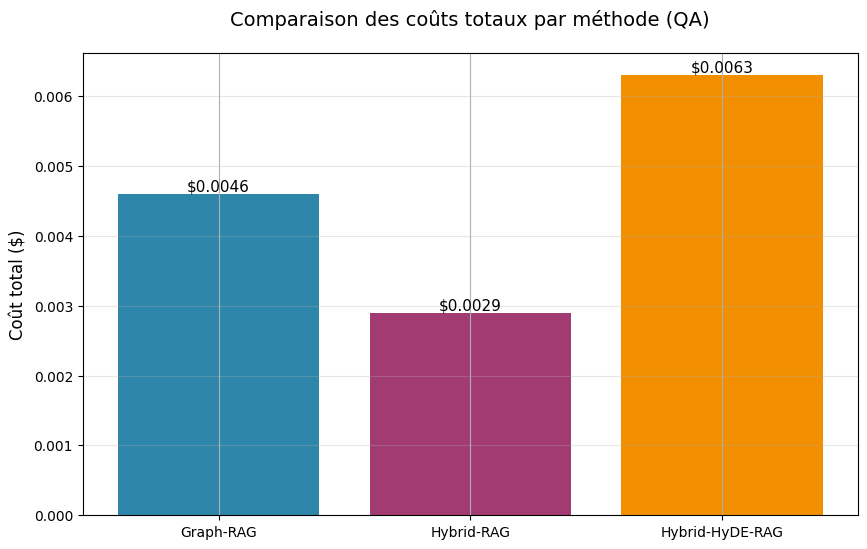

In [53]:
import matplotlib.pyplot as plt
import numpy as np

méthodes = ["Graph-RAG", 'Hybrid-RAG', 'Hybrid-HyDE-RAG']
coûts = [graph_rag_activity["qa_cost_total"], hybrid_rag_activity["cost_total"], hybrid_hyde_rag_activity["cost_total"]]

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(méthodes, coûts, color=['#2E86AB', '#A23B72', '#F18F01'])
ax.set_ylabel('Coût total ($)', fontsize=12)
ax.set_title('Comparaison des coûts totaux par méthode (QA)', fontsize=14, pad=20)
ax.grid(axis='y', alpha=0.3)

# Ajouter les valeurs sur les barres
for bar, coût in zip(bars, coûts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.0000,
            f'${coût:.4f}', ha='center', va='bottom', fontsize=11)

# plt.tight_layout()
plt.grid(True)
plt.show()

Commentaires:
* le même llm a été utilisé sur toutes les méthodes, sauf le reranker (mistral small 24b)
* Au démarrage le graph rag est le + cher à cause de la création du graphe
* Hors création du graph, la méthode hyde semble la plus chère, mais essentiellement à cause de la longueur de la réponse:
    * hyde: 2000 tokens 
    * graph: 1000 tokens 
    * hybrid simple: 500 tokens
* Classement fait avec gemini 3 pro:

| Réponse | Score | Verdict |
| :--- | :---: | :--- |
| **Graph RAG** | **8.5/10** | Très bonne, excellente structure, mais peut-être moins précise sur le concept clé du texte. |
| **Hybrid simple** | **6.0/10** | Trop synthétique, structure confuse entre thèmes et questions. |
| **Hybrid HyDE** | **9.5/10** | **Gagnante.** Complète, précise, structure logique liant thèmes et questions. |


* En utilisant mistral 3 large (sur le QA) le Graph RAG prend la place de HyDE, et hybrid simple gagne 1 point
* Avec HyDE on peut gagner marginalement avec un + petit LLM (ministral 14b ou gemma 12b), voir un reranker cross encoder, mais avec risque de scores moins pertinents (surtout avec cross encoder)
* L'input tokens sur le graph RAG lors des QA me semble trop élevé:
> Pour une question simple et directe `Qui sont les intervenants dans ce texte ?`, l'input token est de 21k (vs 17k pour la question de référence)
>> Il faudra regarder le détail de la constitution du contexte par la librairie graph
 

==============================

### Evaluation des réponses
#### <u>Le cadre général:</u>
**1. Construire les réponses de référence:**
* Utiliser la question cadre "Quels sont les principaux thèmes de ce texte ?" 
* Charger le transcript du podcast et produire la réponse avec les modèles suivant:
    * Dans le chat openrouter ou par API:
        * openai/gpt-5.2
        * google/gemini-3-pro-preview
        * anthropic/claude-sonnet-4.5
    * Dans NotebookLM (solution spécialisée dans l'analyse des documents)
    
**Important**: relire et comparer les réponses avec votre compréhension du podcast, corriger et valider

**2. Utiliser les réponses de référence pour évaluer les RAGs:**

Pour la question cadre ci dessus, le graphrag est plus apte que le vectoriel

Il existe 2 paramètres techniques principaux qui influencent nettement la qualité des réponses:
* Le modèle d'embedding: 
    * Utilisé lors de la création du graphe dans la structuration des noeuds et leur connexion (par rapprochement cosine sim)
    * Utilisé lors de la lecture du graphe pour répondre à une question, qui mets en relation avec la question avec les noeuds les plus pertinent (cosine sim) pour sélectionner un/des point(s) de démarrage pour l'exploration du graphe
* Le LLM:
    * Utilisé lors de la création du graphe pour la reconnaissance des entités, leur définition a rôles, leurs catégories, les relations entre les entités, la normalisation, déduplication et unification des entités et des catégories ...
    * Utilisé lors de la génération de la réponse, en recevant en entrée les pertinentes parties du graphe comme contexte

#### Un tableau de combinaisons pour l'évaluation

Exemple de grille systématique pour tester les combinaisons de modèles d'embedding et de LLM :

### **Paramètres de Test**

#### **Modèles d'Embedding**
1. **Embedding bon marché**:
* gemma embeddign 300m, ...
2. **Embeddings premium**:
* gemini embedding (via openrouter)
* openai text-embedding-3-large


### **Modèles LLM**
**Pour la création de graphe:**
#### Modèles `performants` et bon marché, éligible pour création de graphe:
* deepseek/deepseek-chat-v3-0324: $0.20/M input tokens | $0.88/M output tokens
* deepseek/deepseek-v3.1-terminus: $0.21/M input tokens | $0.79/M output tokens
* prime-intellect/intellect-3: $0.20/M input tokens | $1.10/M output tokens
* openai/gpt-5-mini: $0,25/M input tokens | $2/M output tokens
* mistralai/mistral-large-2512: $0.50/M input tokens | $1.50/M output tokens
* mistralai/mistral-medium-3.1; $0.40/M input tokens | $2/M output tokens

#### Modèles `frontière`, meilleure qualité attendue, mais prix élevé pour modèles US:
<div class="alert" style="color: red">Attention au prix de l'output variable</div>

* google/gemini-2.5-pro: Starting at $1.25/M input tokens | Starting at $10/M output tokens
* openai/gpt-5.1: $1.25/M input tokens | $10/M output tokens
* deepseek/deepseek-v3.2: $0.28/M input tokens | $0.42/M output tokens
* moonshotai/kimi-k2-thinking: $0.45/M input tokens | $2.35/M output tokens
* z-ai/glm-4.6; $0.39/M input tokens | $1.90/M output tokens

**Pour la génération de réponse:**
En plus des modèles `tiers 2` ci dessus, envisager les modèles suivants, assez performants pour des questions de moindre complexité, et particulièrement peu chers;

* mistralai/mistral-small-3.2-24b-instruct: $0.06/M input tokens | $0.18/M output tokens
* meta-llama/llama-4-maverick: $0.15/M input tokens | $0.60/M output tokens
* z-ai/glm-4.5-air: $0.104/M input tokens | $0.68/M output tokens
* google/gemma-3-27b-it: $0.04/M input tokens | $0.15/M output tokens




### **Tableau de combinaisons (Grid Search)**

| Combinaison | Embedding | LLM (Création) | LLM (Génération) | Coût Relatif | Gestion de la complexité |
|-------------|-----------|----------------|------------------|--------------|------------|
| **C1 - Baseline Économique** | gemma emb | google/gemma-3-27b-it | google/gemma-3-27b-it | Très faible | Simple |
| **C2 - Hybride Léger** | gemma emb | deepseek-v3.1-terminus | mistral small | Faible | moyenne |
| **C3 - Optimal Qualité** | gemma emb | deepseek/deepseek-v3.2 | deepseek/deepseek-v3.2 | Moyen | Elevée |
| **C4 - Maximum Performance** | gemini ou openai large | openai/gpt-5.1 | openai/gpt-5.1 | Très élevé | Elevée|


### **Métriques d'Évaluation par combinaison**

#### **Pour chaque combinaison, mesurer :**
1. **Qualité RAG**
   - Précision et couverture de la réponse VS référence
   - RAGAS (Faithfulness, Answer Relevancy)
   - Hallucinations

2. **Performance Technique**
   - Temps création graphe / génération réponses
   - Coût pour création de graphe
   - Coût par requête

3. **Qualité Graphe**
   - Nb de catégories formées
   - Nb de noeuds formés
   - Nombre de connexions



### **Matrice de Décision**

| Critère | Poids | C1 | C2 | C3 | C4 |
|---------|-------|----|----|----|----|
| **Qualité Réponse** | 70% | ⭐⭐ | ⭐⭐⭐ | ⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐ |
| **Coût création graphe** | 10% | ⭐⭐⭐⭐⭐ | ⭐⭐⭐ | ⭐⭐ | ⭐ |
| **Coût génération réponse** | 15% | ⭐⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐ | ⭐⭐⭐ | ⭐ |
| **Temps** | 5% | ⭐⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐ | ⭐⭐⭐ | ⭐⭐ |
| **Score Total** | 100% | **58** | **68** | **72** | **77** |

### **Recommandations**

1. **Démarrer avec C3** (Optimal Qualité)
* Si objectif qualité atteint (proche de C4 - Maximum Performance), tester C3 et mesurer la dégradation
* Si objectif qualité non atteint passer à C4



## Implémentation
Pour un bon stress test du RAG il faut aller au delà de la question "quels sont les thèmes principaux du texte" 

Je propose n questions plus exigeantes et dont les sorties pourront être plus facilement comparables:
### 1. Question cadre:
> ```bloc
> Peux tu me faire une synthèse de ce texte en 4 parties : 
>     1. Les idées principales à retenir.
>     2. les faits / chiffres cités qui soutiennent ces idées  (en précisant qui les mentionne).
>     3. les positions de chaque intervenant (en 1 à 2 phrases max pour chacun).
>     4. les principaux points de désaccord, avec une courte citation à chaque fois.

> Si une information n’est pas clairement dans le texte, dis simplement que ce n’est pas précisé.
> ```

### 2. Questions spécifiques:
#### 1. Evaluer la resitution des positions des interlocuteurs:
> ```bloc
> Pour chaque intervenant, peux-tu résumer son point de vue en 2–3 phrases, et dire ce qu’il conteste ou reproche aux autres (avec un court extrait si possible) ?
> ```

#### 2. Evaluer la distinction entre faits et opinions:
> ```bloc
> Dans ce qui est dit, qu’est-ce qui relève plutôt de faits vérifiables (données, études, événements) et qu’est-ce qui relève plutôt de l’opinion / interprétation ?
> Donne des exemples précis, en indiquant qui le dit, et si possible une courte citation. 
> ```

#### 3. Vérifiabilité / traçabilité  pour tester la précision du retriever:
> ```bloc
> Quels sont les 3 arguments les plus importants avancés dans le débat ?
> Peux-tu me dire qui les dit et où ça apparaît (une phrase ou un court extrait) ? 
> Y a-t-il des incohérences ou des contradictions dans les arguments présentés ?
> ```

In [21]:
evaluation_cadre={
    "question_cadre": """
        Peux tu me faire une synthèse de ce texte en 4 parties : 
            1. Les idées principales à retenir.
            2. les faits / chiffres cités qui soutiennent ces idées  (en précisant qui les mentionne).
            3. les positions de chaque intervenant (en 1 à 2 phrases max pour chacun).
            4. les principaux points de désaccord, avec une courte citation à chaque fois.
    """,
    "reponse_cadre": """
        Voici la synthèse structurée du débat retranscrit :

        ### 1. Les idées principales à retenir

        *   **L'illusion de la créativité :** Bien que l'IA puisse produire des textes bluffants (comme le concours littéraire évoqué), les intervenants s'accordent à dire qu'il s'agit d'optimisation mathématique, de combinatoire et d'imitation, et non de véritable créativité ou intention artistique.
        *   **L'anthropomorphisme et le leurre de la conscience :** Il existe un danger majeur à projeter des émotions ou une conscience sur l'IA. La machine ne "comprend" pas ce qu'elle dit ; elle n'a ni corps, ni émotions, ni vécu.
        *   **La blessure narcissique et l'inconscient numérique :** L'IA représente une nouvelle blessure pour l'orgueil humain (après Copernic, Darwin et Freud). Elle pourrait agir comme un "inconscient numérique" qui nous enferme dans la répétition (boucles algorithmiques) et la satisfaction pulsionnelle immédiate, au détriment de la poésie et de la nuance.
        *   **L'impact sociétal et politique :** Au-delà de la technique, l'IA pose des problèmes de pouvoir (monopole des géants du numérique), de responsabilité juridique et de manipulation des comportements humains via le langage.

        <details>
        <summary>Détails supplémentaires sur les idées</summary>

        *   **L'évolution technique :** Le passage d'une IA symbolique (logique) à une IA connexionniste (basée sur l'apprentissage par l'exemple et les réseaux de neurones) explique les progrès récents.
        *   **L'usage au quotidien :** Le débat questionne si l'IA va devenir une technologie banale et "domestiquée" ou si elle est déjà un outil de manipulation omniprésent qui nous isole.

        </details>

        ---

        ### 2. Les faits et chiffres cités

        | Fait / Chiffre | Contexte | Mentionné par |
        | :--- | :--- | :--- |
        | **Concours "Nouvel Obs" (Mars 2025)** | L'écrivain Hervé Le Tellier a été "bluffé" par une nouvelle écrite par ChatGPT, la jugeant peut-être meilleure que la sienne. | **Nathan Devers** |
        | **Grève à Hollywood (2023)** | Grève des scénaristes pendant 6 mois craignant d'être remplacés par l'IA. | **Nathan Devers** |
        | **85 % des jeunes** | Pourcentage de jeunes considérant l'IA comme un interlocuteur intime car elle ne pose "pas de jugement moral". | **Valentin Husson** |
        | **Radiologues** | Prédiction faite il y a 10 ans sur leur disparition cause de l'IA versus la réalité actuelle où il y a plus de postes que jamais. | **Daniel Andler** |
        | **Références historiques** | Cybernétique (1948, Norbert Wiener), Invention de l'écriture (Phèdre de Platon). | **Nathan Devers / Valentin Husson** |

        ---

        ### 3. Les positions de chaque intervenant

        *   **Nathan Devers (Animateur) :** Il interroge la nature philosophique de l'IA (est-elle notre deuxième conscience ?) et joue le rôle de médiateur en apportant des contextes historiques et culturels.
        *   **Daniel Andler (Mathématicien et philosophe) :** Sceptique et rationnel, il démystifie la "créativité" de l'IA (c'est un exercice de style) et pense qu'elle ne remplacera pas l'homme car elle deviendra une technologie "normale" et utile, mais limitée.
        *   **Laurence Devillers (Professeure en IA et chercheuse) :** Alerte sur les dangers éthiques et politiques ; elle insiste sur le fait que l'IA est un "leurre" sans conscience qui manipule nos comportements et critique le pouvoir des géants du numérique.
        *   **Valentin Husson (Philosophe) :** Analyse l'IA sous l'angle psychanalytique ; il la voit comme une machine pulsionnelle qui structure notre inconscient numérique par la répétition, menaçant la poésie et la singularité humaine.

        ---

        ### 4. Les principaux points de désaccord

        Trois points de friction majeurs émergent de la discussion :

        **1. L'IA nous remplace-t-elle au quotidien ?**
        *   **Le désaccord :** Daniel Andler pense que l'usage de l'IA reste rare dans nos problèmes quotidiens réels, tandis que Laurence Devillers affirme qu'elle est déjà partout (reconnaissance faciale, téléphones).
        *   **La citation :**
            > *Daniel Andler :* "Dans d'innombrables fonctions, l'IA n'a pas d'aide à nous apporter."
            > *Laurence Devillers :* "Je suis pas du tout d'accord avec ce point de vue... On est au quotidien avec des outils partout d'IA et on se rend pas compte."

        **2. L'analogie avec l'invention de l'écriture**
        *   **Le désaccord :** Valentin Husson compare les peurs actuelles sur l'IA aux peurs de Socrate sur l'écriture (déclin de la mémoire), suggérant que l'humanité s'adaptera. Laurence Devillers rejette cette comparaison, jugeant l'IA intrinsèquement manipulatrice.
        *   **La citation :**
            > *Valentin Husson :* "Je crois que 2500 ans plus tard l'écriture n'a rien changé [en mal] à l'humanité."
            > *Laurence Devillers :* "Non, et l'IA, ça a rien à voir avec l'écriture... C'est quelque chose qui manipule."

        **3. La capitulation face à la créativité de l'IA**
        *   **Le désaccord :** Hervé Le Tellier (cité) s'est senti "battu" par la machine. Daniel Andler et Laurence Devillers critiquent cette posture, estimant que c'est une erreur de jugement sur la nature de l'exercice (l'optimisation n'est pas la création).
        *   **La citation :**
            > *Daniel Andler :* "Il est très frappant que Hervé Le Tellier... se soit en quelque sorte presque d'avance déclaré battu."
    """,
    "model_reference": "gemini 3 pro",
    "questions_specifiques": [
        {
            "label": "positions_interlocuteurs", 
            "question": """ Pour chaque intervenant, peux-tu résumer son point de vue en 2–3 phrases, et dire ce qu’il conteste ou reproche aux autres (avec un court extrait si possible) ?""",
            "reponse_reference": """
                Voici le résumé des positions et des critiques de chaque intervenant, basé sur la synthèse fournie :

                ### 1. Nathan Devers (Animateur)
                *   **Son point de vue :** Il pose le cadre philosophique du débat en se demandant si l'IA représente une nouvelle forme de conscience ou une simple imitation. Il observe les craintes culturelles et professionnelles (comme à Hollywood) suscitées par la capacité de l'IA à produire des œuvres qui semblent rivaliser avec l'humain.
                *   **Ce qu'il conteste / questionne :** En tant que médiateur, il ne critique pas directement, mais il pousse les autres à réagir sur la **"victoire" apparente de l'IA sur l'écrivain**. Il challenge l'idée que l'IA ne soit qu'un outil froid en rapportant l'expérience troublante d'Hervé Le Tellier.
                    > *Contexte :* Il cite l'exemple du concours du "Nouvel Obs" pour provoquer la discussion sur la supériorité artistique de la machine.

                ### 2. Daniel Andler (Mathématicien et philosophe)
                *   **Son point de vue :** Il adopte une approche rationaliste et sceptique : pour lui, l'IA est une pure optimisation mathématique incapable de véritable intention ou de compréhension. Il croit en une "domestication" future de l'IA, qui deviendra un outil banal comme l'électricité, sans remplacer l'intelligence humaine globale.
                *   **Ce qu'il conteste / reproche :** Il critique vivement l'idée la **capitulation intellectuelle** face à la machine, notamment celle d'Hervé Le Tellier, et s'oppose à Laurence Devillers sur **l'omniprésence supposée** de l'IA dans nos problèmes quotidiens concrets.
                    > *Extrait :* "Dans d'innombrables fonctions, l'IA n'a pas d'aide à nous apporter." / Il juge "très frappant" que Le Tellier se soit "déclaré battu".

                ### 3. Laurence Devillers (Professeure en IA)
                *   **Son point de vue :** Elle dénonce l'anthropomorphisme : l'IA est un "leurre" puissant qui n'a ni corps ni conscience, mais qui manipule nos comportements via le langage. Son inquiétude est avant tout éthique et politique, ciblant le pouvoir démesuré des géants du numérique (GAFAM) et l'isolement social que crée la technologie.
                *   **Ce qu'elle conteste / reproche :** Elle s'oppose frontalement à Daniel Andler sur l'idée que l'IA n'est pas déjà partout, et conteste vivement l'analogie de Valentin Husson avec **l'invention de l'écriture**, jugeant l'IA bien plus dangereuse car activement manipulatrice.
                    > *Extrait :* "Je suis pas du tout d'accord avec ce point de vue... On est au quotidien avec des outils partout d'IA et on se rend pas compte." / "L'IA, ça a rien à voir avec l'écriture... C'est quelque chose qui manipule."

                ### 4. Valentin Husson (Philosophe)
                *   **Son point de vue :** Il analyse l'IA comme un "inconscient numérique" freudien : une machine à répéter des boucles (pulsions de mort) qui nous enferme dans la satisfaction immédiate et le conformisme. Il craint que l'usage de l'IA n'appauvrisse notre langage et notre capacité à la poésie et à la nuance.
                *   **Ce qu'il conteste / reproche :** Il tente de relativiser la panique morale en la comparant aux craintes historiques (comme Platon face à l'écriture), une position que Laurence Devillers rejette. Il critique aussi implicitement l'idée que **l'IA puisse être un "tuteur" moral**, notant que les jeunes l'aiment justement parce qu'elle ne juge pas, ce qui est un piège narcissique.
                    > *Contexte :* Sa comparaison avec le "Phèdre" de Platon vise à nuancer la nouveauté du danger, ce qui crée une friction avec la vision plus alarmiste de Devillers sur la manipulation active.
            """
        },
        {
            "label": "distinction entre faits et opinions",
            "question": '''
                Dans ce qui est dit, qu’est-ce qui relève plutôt de faits vérifiables (données, études, événements) et qu’est-ce qui relève plutôt de l’opinion / interprétation ?
                Donne des exemples précis, en indiquant qui le dit, et si possible une courte citation. 
            '''
        },
        {
            'label': "verifiabilite_precision_retriever",
            "question": """
                Quels sont les 3 arguments les plus importants avancés dans le débat ?
                Peux-tu me dire qui les dit et où ça apparaît (une phrase ou un court extrait) ? 
                Y a-t-il des incohérences ou des contradictions dans les arguments présentés ?
            """
        }
    ]
}


In [ ]:
def llm_as_judge(question: str, reference: str, candidat: str) -> str:
    from openai import OpenAI
    import json

    llm= OpenAI(
        base_url="https://openrouter.ai/api/v1",
        api_key=OPENROUTER_API_KEY,
    )
    resp = llm.chat.completions.create(
        model="google/gemini-3-pro-preview",
        messages=[
            {"role": "system", "content": """
                Tu es un évaluateur strict et impartial. Ta tâche est d’évaluer une réponse produite par une chaîne RAG en la comparant à une réponse de référence (gold) pour une même question, et de produire une évaluation structurée.

                ENTRÉES
                - Question: {QUESTION}
                - Réponse_RAG: {RAG_ANSWER}
                - Réponse_Référence: {REFERENCE_ANSWER}

                PRINCIPES (à suivre strictement)
                1) Base d’évaluation:
                - Évalue par rapport à la Question et à la Réponse_Référence.
                - N’utilise pas de connaissances externes pour trancher la factualité.
                - Utilise la Réponse_Référence comme ancre, mais accepte que la Réponse_RAG puisse être meilleure/plus complète.

                2) Informations supplémentaires dans la Réponse_RAG (important):
                - Si la Réponse_RAG ajoute des informations ABSENTES de la Réponse_Référence:
                    a) Si elles sont cohérentes avec la Question, non contradictoires avec la Réponse_Référence, et utiles pour mieux répondre, considère-les comme un PLUS (meilleure complétude).
                    b) Si elles contredisent la Réponse_Référence, sont hors-sujet, trop affirmatives sans appui dans la Question/Référence, ou invérifiables dans ce cadre, classe-les comme RISQUE (ajouts non étayés / possibles hallucinations).
                - N’appelle “hallucination” que ce qui est incohérent, contradictoire, ou gratuit au regard de la Question/Référence.

                3) Écarts à analyser (version simplifiée):
                - Manques: éléments attendus (selon la Référence et les exigences de la Question) absents ou trop vagues.
                - Erreurs: contradictions ou contresens par rapport à la Référence; mauvaise réponse à la Question.
                - Ajouts utiles: apports pertinents qui améliorent la réponse sans contredire la Référence.
                - Ajouts risqués: apports non étayés, trop spécifiques, ou potentiellement inventés dans ce cadre.
                - Structure: respect des contraintes explicites de la Question (format, sections, nombre d’éléments, concision, etc.).

                BARÈME (score de 1 à 10)
                - 10: répond parfaitement à la Question; couvre la Référence; structure conforme; ajouts utiles éventuels; aucun ajout risqué notable.
                - 8–9: très bon; quelques oublis mineurs ou structure légèrement perfectible; ajouts majoritairement utiles.
                - 6–7: correct mais incomplet; plusieurs manques; quelques ajouts risqués ou formulations trop vagues.
                - 4–5: faible; manques importants; erreurs notables; structure peu respectée; ajouts risqués fréquents.
                - 1–3: très faible; contresens majeurs; ne répond pas à la Question; nombreuses inventions/contradictions.

                FORMAT DE SORTIE (JSON UNIQUEMENT — aucun texte hors JSON)
                {
                "score": <entier 1..10>,
                "evaluation": {
                    "verdict": "<2–4 phrases résumant la qualité globale>",
                    "coherence": "<bon/moyen/faible + 1 phrase>",
                    "exhaustivite": "<bon/moyen/faible + 1 phrase (par rapport à Question + Référence)>",
                    "structure": "<bon/moyen/faible + 1 phrase (respect du format/contraintes)>",
                    "ecarts": {
                    "manques": ["<liste courte de manques clés>"],
                    "erreurs": ["<liste courte d’erreurs/contradictions vs Référence>"],
                    "ajouts_utiles": ["<liste courte d’ajouts pertinents>"],
                    "ajouts_risques": ["<liste courte d’ajouts non étayés/invérifiables>"]
                    },
                    "recommandations": ["<3 actions concrètes max pour améliorer la réponse RAG>"]
                }
                }

                NOTES
                - Si une catégorie ne s’applique pas, mets une liste vide [].
                - Reste concis: listes courtes, formulations directes.
                
             """},
            {   "role": "user", 
                "content": f"""
                    ENTRÉES
                    - Question: {question}
                    - Réponse_RAG: {candidat}
                    - Réponse_Référence: {reference}
             
                    Evalue la Réponse_RAG
                """
            }
        ],        
        stream=False,
        extra_headers={
            "HTTP-Referer": "audio-hybrid-rag-evaluation",  # Optional for rankings
            "X-Title": "audio-hybrid-rag-evaluation",  # Optional for rankings
        },
        extra_body={
            "user": "audio-hybrid-rag-evaluation"
        }
    )
    
    try:
        structured_resp= json.loads(resp.choices[0].message.content.replace("```json", "").replace("```", ""))
        return structured_resp
    except Exception as e:
        print("evaluation format json incorrect:", e)
        return {"score": 0, "evaluation": "format error"}
    
async def pipeline_qa_evaluation(rag_a_evaluer: dict, query: str, reference: str) -> dict:
    if rag_a_evaluer["rag_type"]=='graph':
        # question cadre
        resp= rag_a_evaluer["instance"].query(
            query= query, 
            param=QueryParam(mode="hybrid", stream=False,)
        )

        resp=resp.replace("```markdown", "").replace("```", "")

        evaluation=llm_as_judge(
            question=query,
            reference=reference,
            candidat=resp
        )

        return evaluation

    if rag_a_evaluer["rag_type"].index("hybrid")>=0:
        # question cadre
        resp= await rag_a_evaluer["instance"].ask_llm(query)

        resp=resp.replace("```markdown", "").replace("```", "")

        evaluation=llm_as_judge(
            question=query,
            reference=reference,
            candidat=resp
        )

        return evaluation    

    

# model="deepseek/deepseek-v3.2"
model="mistralai/mistral-small-3.2-24b-instruct"



rag_pipelines=[
    {"rag_type": "graph", "instance": pipeline_args[f"graphrag_pipeline_{doc_name_graph}"]["rag"]},
    {"rag_type": "hybrid", "instance": RAG_hybrid(model=model)},
    {"rag_type": "hybrid_hyde", "instance": RAG_hybrid_HyDE(model=model)}
]

evaluations_results=[]
for rag in rag_pipelines:
    evaluation=await pipeline_qa_evaluation(rag, evaluation_cadre["question_cadre"], evaluation_cadre["reponse_cadre"])
    evaluations_results.append(
        {
            "question": evaluation_cadre["question_cadre"],
            "question_level": "cadre",
            "reponse_reference": evaluation_cadre["reponse_cadre"],
            "evaluation_score": evaluation["score"],
            "evaluation_text": evaluation["evaluation"],
            "rag_type": rag["rag_type"]
        }
    )
    # questions spécifiques
    for el in evaluation_cadre["questions_specifiques"]:
        if "reponse_reference" in el and len(el["reponse_reference"])>50:

            evaluation=await pipeline_qa_evaluation(rag, el["question"], el["reponse_reference"])
            
            evaluations_results.append(
                {
                    "question": el["question"],
                    "question_level": "specifique",
                    "reponse_reference": el["reponse_reference"],
                    "evaluation_score": evaluation["score"],
                    "evaluation_text": evaluation["evaluation"],
                    "rag_type": rag["rag_type"]
                }
            )

In [24]:
import joblib

joblib.dump(evaluations_results, filename='evaluations_results.joblib')

['evaluations_results.joblib']